In [1]:
import os, sys
from ruamel.yaml import YAML
import numpy as np
import pandas as pd
import math
from typing import Dict, Optional
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from einops import rearrange
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision.transforms import RandomRotation
from torch.utils.data import TensorDataset, DataLoader, random_split
from src.models_multimodal import (
    ConvMixer,
    TransformerWithTimeEmbeddings,
    LightCurveImageCLIP,
)
from src.utils import (
    get_valid_dir,
    LossTrackingCallback,
    plot_loss_history,
    get_embs,
    find_indices_in_arrays,
    get_AUC,
    LossTrackingCallback,
    cosine_similarity,
    plot_ROC_curves,
    get_ROC_data,
)
from src.dataloader import (
    load_images,
    load_lightcurves,
    plot_lightcurve_and_images,
    load_spectras,
    load_data,
    NoisyDataLoader,
    load_redshifts,
)
from src.loss import sigmoid_loss, clip_loss
from typing import Tuple
from src.transformer_utils import Transformer

from IPython.display import Image as IPImage

device = "cuda" if torch.cuda.is_available() else "cpu"

%load_ext autoreload
%autoreload 2

In [208]:
!nvidia-smi

Fri Apr 19 10:20:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB           On | 00000000:06:00.0 Off |                  Off |
| N/A   30C    P0               34W / 250W|  39137MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### Loading SLSN-I supernovae

In [2]:
data_dirs = [
    "./data/ZTFBTS/",
    "/home/thelfer1/scr4_tedwar42/thelfer1/ZTFBTS/",
    "ZTFBTS/",
    "/ocean/projects/phy230064p/shared/ZTFBTS/",
    "/n/home02/gemzhang/repos/Multimodal-hackathon-2024/data/ZTFBTS/",
]

# Get the first valid directory
data_dir = get_valid_dir(data_dirs)

In [3]:
data_dir

'/home/thelfer1/scr4_tedwar42/thelfer1/ZTFBTS/'

In [4]:
# load the filenames of SLSN-I supernovae
df = pd.read_csv(f"{data_dir}ZTFBTS_TransientTable.csv")
filenames_SLSNI = df[df["type"] == "SLSN-I"]["ZTFID"].to_list()[0:1]

In [5]:
filenames = df["ZTFID"].to_list()

In [41]:
ims, ims_names = load_images(f"{data_dir}")
time_ary, mag_ary, magerr_ary, mask_ary, _, lc_names = load_lightcurves(f"{data_dir}")


Loading images...


100%|██████████| 5171/5171 [00:19<00:00, 263.71it/s] 


Loading light curves...


100%|██████████| 5170/5170 [00:20<00:00, 256.69it/s]


In [6]:
# load the data for SLSN-I supernovae and all of the images
ims_SLSNI, _ = load_images(f"{data_dir}", filenames_SLSNI)

# freq_ary_SLSNI, spec_ary_SLSNI, specerr_ary_SLSNI, specmask_ary_SLSNI, spec_names_SLSNI = load_spectras("./data/ZTFBTS_spectra/",
#                                                                                                    filenames=filenames_SLSNI)
(
    time_ary_SLSNI,
    mag_ary_SLSNI,
    magerr_ary_SLSNI,
    mask_ary_SLSNI,
    _,
    lc_names_SLSNI,
) = load_lightcurves(f"{data_dir}", filenames=filenames_SLSNI)

Loading images...


100%|██████████| 1/1 [00:00<00:00, 288.80it/s]


Loading light curves...


100%|██████████| 1/1 [00:00<00:00, 57.22it/s]


In [7]:
data_dirs = ["ZTFBTS_spectra/", "/n/home02/gemzhang/Storage/multimodal/ZTFBTS_spectra/"]
spectra_dir = get_valid_dir(data_dirs)
combinations = ["lightcurve", "spectral",'host_galaxy']

max_spectral_data_len = 1000  # Spectral data is cut to this length
dataset, nband, lc_filenames = load_data(
    data_dir, spectra_dir, max_data_len_spec = max_spectral_data_len, combinations=combinations
)

Loading images...


100%|██████████| 5171/5171 [00:10<00:00, 471.71it/s] 


Loading light curves...


100%|██████████| 5170/5170 [00:15<00:00, 325.69it/s]


Loading spectra ...


100%|██████████| 5021/5021 [00:17<00:00, 286.41it/s]


Loading redshifts...


### Setting up model from checkpoint

In [8]:
# load a trained model and its config
path = "./models/lightcurve-galaxy/ethereal-sweep-4/epoch=493-step=76076.ckpt"
cfg = YAML(typ="safe").load(open(f"{os.path.dirname(path)}/config.yaml"))
print(cfg)

# Setting parameters for models
transformer_kwargs = {
    "n_out": cfg["n_out"],
    "emb": cfg["emb"],
    "heads": cfg["heads"],
    "depth": cfg["transformer_depth"],
    "dropout": cfg["dropout"],
    "time_norm": cfg["time_norm"],
}

transformer_spectral_kwargs = {
    "n_out": cfg["n_out"],
    "emb": cfg["emb_spectral"],
    "heads": cfg["heads"],
    "depth": cfg["transformer_depth_spectral"],
    "dropout": cfg["dropout"],
    "time_norm": cfg["time_norm_spectral"],
}

conv_kwargs = {
    "dim": 32,
    "depth": cfg["cnn_depth"],
    "channels": 3,
    "kernel_size": 5,
    "patch_size": 10,
    "n_out": cfg["n_out"],
    "dropout_prob": cfg["dropout"],
}

model = LightCurveImageCLIP(
    logit_scale=cfg["logit_scale"],
    lr=cfg["lr"],
    nband=2,
    loss="softmax",
    transformer_kwargs=transformer_kwargs,
    transformer_spectral_kwargs=transformer_spectral_kwargs,
    conv_kwargs=conv_kwargs,
    optimizer_kwargs={},
    combinations=["host_galaxy", "lightcurve"],
)
model.to(device)
model.load_state_dict(torch.load(path, map_location=torch.device(device))["state_dict"])
model.eval();

{'agg': 'mean', 'agg_spectral': 'mean', 'batchsize': 32, 'cnn_depth': 7, 'dropout': 0.0072484609941876, 'emb': 64, 'emb_spectral': 32, 'epochs': 500, 'heads': 8, 'heads_spectral': 8, 'logit_scale': 8.471890237718537, 'lr': 2.481529679233978e-05, 'n_out': 32, 'seed': 0, 'time_norm': 363.0794848503694, 'time_norm_spectral': 7405.896275312251, 'transformer_depth': 16, 'transformer_depth_spectral': 2, 'weight_decay': 7.287157067362061e-05}


In [9]:
# load a trained trimodal model and its config
path = "./models/trimodal/prime-sweep-81/epoch=287-step=43200.ckpt"
cfg = YAML(typ="safe").load(open(f"{os.path.dirname(path)}/config.yaml"))
print(cfg)

transformer_kwargs = {
    "n_out": cfg["n_out"],
    "emb": cfg["emb"],
    "heads": cfg["heads"],
    "depth": cfg["transformer_depth"],
    "dropout": cfg["dropout"],
    "time_norm": cfg["time_norm"],
    "agg": cfg["agg"],
}

transformer_spectral_kwargs = {
    "n_out": cfg["n_out"],
    "emb": cfg["emb_spectral"],
    "heads": cfg["heads"],
    "depth": cfg["transformer_depth_spectral"],
    "dropout": cfg["dropout"],
    "time_norm": cfg["time_norm_spectral"],
    "agg": cfg["agg_spectral"],
}

conv_kwargs = {
    "dim": 32,
    "depth": cfg["cnn_depth"],
    "channels": 3,
    "kernel_size": 5,
    "patch_size": 10,
    "n_out": cfg["n_out"],
    "dropout_prob": cfg["dropout"],
}

model_tri = LightCurveImageCLIP(
    logit_scale=cfg["logit_scale"],
    lr=cfg["lr"],
    nband=2,
    loss="softmax",
    transformer_kwargs=transformer_kwargs,
    transformer_spectral_kwargs=transformer_spectral_kwargs,
    conv_kwargs=conv_kwargs,
    optimizer_kwargs={},
    combinations=["host_galaxy", "lightcurve", "spectral"],
)
# load weights
model_tri.load_state_dict(
    torch.load(path, map_location=torch.device(device))["state_dict"]
)
model_tri.to(device);
model_tri.eval();
# load spectral embedding
# sp_emb_SLSNI = model_tri.spectral_embeddings_with_projection(torch.from_numpy(spec_ary_SLSNI).to(torch.float32),
#                                                     torch.from_numpy(freq_ary_SLSNI).to(torch.float32),
#                                                     torch.from_numpy(specmask_ary_SLSNI).to(torch.bool))

{'agg': 'mean', 'agg_spectral': 'mean', 'batchsize': 32, 'cnn_depth': 5, 'dropout': 0.009971398925813077, 'emb': 64, 'emb_spectral': 64, 'epochs': 800, 'heads': 4, 'heads_spectral': 8, 'logit_scale': 17.415645235447595, 'lr': 6.484310725110905e-05, 'n_out': 32, 'seed': 0, 'time_norm': 7176.357302735578, 'time_norm_spectral': 9124.730024216396, 'transformer_depth': 3, 'transformer_depth_spectral': 15, 'weight_decay': 1.0795800085560923e-05}


In [10]:
# load a trained trimodal model and its config
path = "./analysis/pysdqyua/earthy-sweep-1/epoch=248-step=37350.ckpt"
cfg = YAML(typ="safe").load(open(f"{os.path.dirname(path)}/config.yaml"))
print(cfg)

transformer_kwargs = {
    "n_out": cfg["n_out"],
    "emb": cfg["emb"],
    "heads": cfg["heads"],
    "depth": cfg["transformer_depth"],
    "dropout": cfg["dropout"],
    "time_norm": cfg["time_norm"],
    "agg": cfg["agg"],
}

transformer_spectral_kwargs = {
    "n_out": cfg["n_out"],
    "emb": cfg["emb_spectral"],
    "heads": cfg["heads"],
    "depth": cfg["transformer_depth_spectral"],
    "dropout": cfg["dropout"],
    "time_norm": cfg["time_norm_spectral"],
    "agg": cfg["agg_spectral"],
}

conv_kwargs = {
    "dim": 32,
    "depth": cfg["cnn_depth"],
    "channels": 3,
    "kernel_size": 5,
    "patch_size": 10,
    "n_out": cfg["n_out"],
    "dropout_prob": cfg["dropout"],
}

model_tri_red = LightCurveImageCLIP(
    logit_scale=cfg["logit_scale"],
    lr=cfg["lr"],
    nband=2,
    loss="softmax",
    transformer_kwargs=transformer_kwargs,
    transformer_spectral_kwargs=transformer_spectral_kwargs,
    conv_kwargs=conv_kwargs,
    optimizer_kwargs={},
    combinations=["host_galaxy", "lightcurve", "spectral"],
)
# load weights
model_tri_red.load_state_dict(
    torch.load(path, map_location=torch.device(device))["state_dict"]
)
model_tri_red.to(device);
model_tri_red.eval();
# load spectral embedding
# sp_emb_SLSNI = model_tri.spectral_embeddings_with_projection(torch.from_numpy(spec_ary_SLSNI).to(torch.float32),
#                                                     torch.from_numpy(freq_ary_SLSNI).to(torch.float32),
#                                                     torch.from_numpy(specmask_ary_SLSNI).to(torch.bool))

{'agg': 'mean', 'agg_spectral': 'mean', 'batchsize': 32, 'cnn_depth': 12, 'dropout': 0.008166089333851906, 'emb': 32, 'emb_spectral': 64, 'epochs': 3000, 'heads': 2, 'heads_spectral': 8, 'logit_scale': 2.6913538793596112, 'lr': 2.8450806840833268e-05, 'n_out': 32, 'seed': 0, 'time_norm': 24895.51923329118, 'time_norm_spectral': 13928.111078819822, 'transformer_depth': 16, 'transformer_depth_spectral': 9, 'weight_decay': 0.0001953041732629436}


In [60]:
data_loader = NoisyDataLoader(
    dataset,
    batch_size=128,
    noise_level_img=0,
    noise_level_mag=0,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    combinations=combinations,
)

### Calculate embeddings 

In [71]:
# get embeddings of all images and the first lightcurve in filenames_SLSNI
ims_emb_SLSNI = model.image_embeddings_with_projection(ims_SLSNI.to(device))
lc_emb_SLSNI = model.lightcurve_embeddings_with_projection(
    torch.from_numpy(mag_ary_SLSNI).to(torch.float32).to(device),
    torch.from_numpy(time_ary_SLSNI).to(torch.float32).to(device),
    torch.from_numpy(mask_ary_SLSNI).to(torch.bool).to(device),
)

In [91]:
ims_emb = get_embs(model, data_loader, ["host_galaxy"])
lc_emb = get_embs(model, data_loader, ["lightcurve"])
lc_emb = lc_emb[0]
ims_emb = ims_emb[0]

In [92]:
SN_types = [df.loc[df["ZTFID"] == x, "type"].values[0] for x in lc_filenames]

In [93]:
# get their cosine similarity
cos_sim_lc = cosine_similarity(lc_emb, lc_emb_SLSNI)

In [94]:
cos_sim_im = cosine_similarity(ims_emb, ims_emb_SLSNI)

In [95]:
joint_emb = torch.cat((ims_emb, lc_emb), 1)
joint_emb_SLSNI = torch.cat((ims_emb_SLSNI, lc_emb_SLSNI), 1)

In [96]:
cos_sim_joint = cosine_similarity(joint_emb, joint_emb_SLSNI)

In [97]:
np.unique(SN_types)

array(['Ca-rich', 'SLSN-I', 'SLSN-II', 'SN II', 'SN II-pec', 'SN IIP',
       'SN IIb', 'SN IIn', 'SN Ia', 'SN Ia-91T', 'SN Ia-91bg',
       'SN Ia-CSM', 'SN Ia-SC', 'SN Ia-pec', 'SN Iax', 'SN Ib',
       'SN Ib-pec', 'SN Ib/c', 'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Ic-pec',
       'SN Icn'], dtype='<U10')

In [98]:
SLSN_bool = np.array([False] * len(SN_types))
SN_types = np.array(SN_types)
longlived_bool = np.array([False] * len(SN_types))

In [99]:
SLSN_bool = (SN_types == "SLSN-I") | (SN_types == "SLSN-II")

longlived_bool = (
    (SN_types == "SN IIn")
    | (SN_types == "TDE")
    | (SN_types == "SLSN-I")
    | (SN_types == "SLSN-II")
    | (SN_types == "SN IIP")
)

In [100]:
from collections import Counter

Counter(SN_types[cos_sim_joint.cpu().detach() > 0.9])

Counter({'SN Ia': 84,
         'SN II': 9,
         'SN Ia-91T': 7,
         'SN IIb': 1,
         'SLSN-II': 1,
         'SN IIn': 4,
         'SLSN-I': 1,
         'SN Ia-pec': 1,
         'SN Ic-BL': 1})

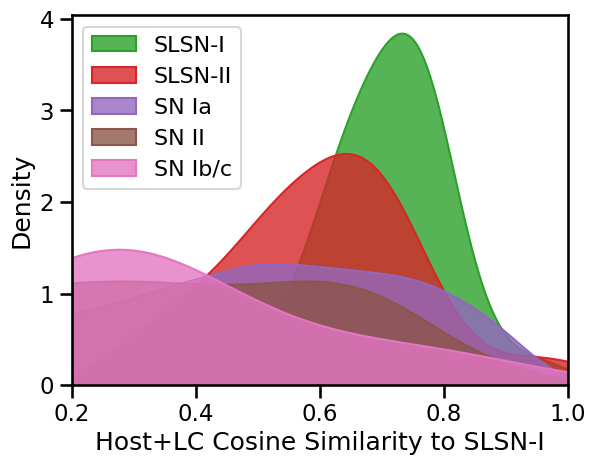

In [101]:
sns.set_context("talk")
for tempType in ["Ca-Rich", "ILRT", "SLSN-I", "SLSN-II", "SN Ia", "SN II", "SN Ib/c"]:
    sns.kdeplot(
        cos_sim_joint.cpu().detach()[SN_types == tempType],
        alpha=0.8,
        label=tempType,
        fill=True,
    )
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("Host+LC Cosine Similarity to SLSN-I")
plt.xlim((0.2, 1));

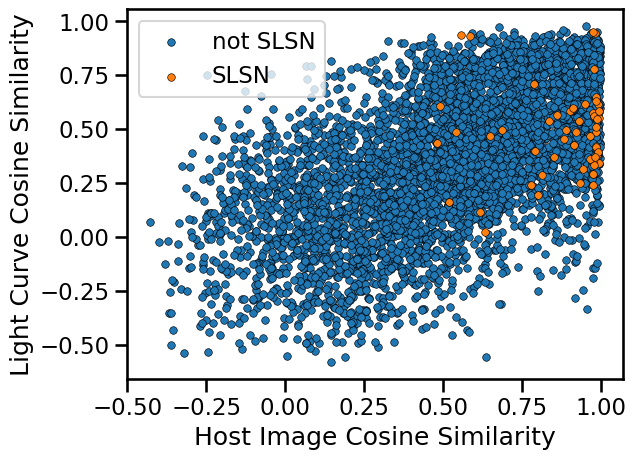

In [102]:
sns.scatterplot(
    x=cos_sim_im.cpu().detach()[~SLSN_bool],
    y=cos_sim_lc.cpu().detach()[~SLSN_bool],
    marker="o",
    s=30,
    ec="k",
    legend=False,
    label="not SLSN",
)
sns.scatterplot(
    x=cos_sim_im.cpu().detach()[SLSN_bool],
    y=cos_sim_lc.cpu().detach()[SLSN_bool],
    marker="o",
    s=30,
    ec="k",
    legend=False,
    label="SLSN",
)
plt.xlabel("Host Image Cosine Similarity")
plt.ylabel("Light Curve Cosine Similarity")
plt.legend()

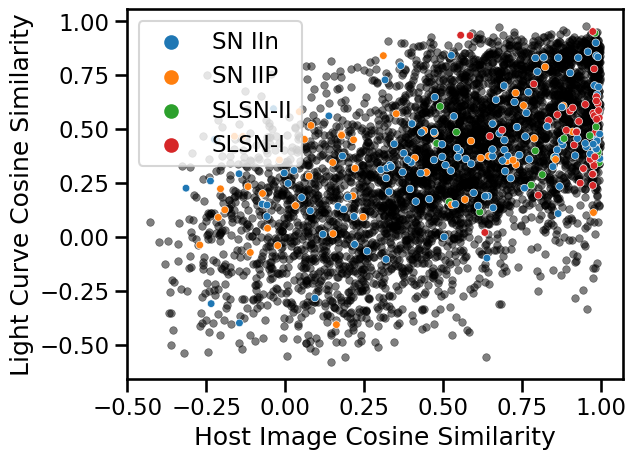

In [103]:
sns.scatterplot(
    x=cos_sim_im.cpu().detach()[~longlived_bool],
    y=cos_sim_lc.cpu().detach()[~longlived_bool],
    marker="o",
    s=30,
    ec="k",
    c="k",
    legend=False,
    alpha=0.5,
)
sns.scatterplot(
    x=cos_sim_im.cpu().detach()[longlived_bool],
    y=cos_sim_lc.cpu().detach()[longlived_bool],
    hue=SN_types[longlived_bool],
    marker="o",
    s=30,
    legend=True,
)
plt.xlabel("Host Image Cosine Similarity")
plt.ylabel("Light Curve Cosine Similarity");

### Load Redshifts

In [216]:
zs_im = load_redshifts(f"{data_dir}", lc_filenames)
zs_im[np.where(zs_im != zs_im)] = np.mean(zs_im[np.where(zs_im == zs_im)]) 

Loading redshifts...


In [152]:
ims_embs_imlc = get_embs(model, data_loader, ["host_galaxy"])
ims_embs_tri = get_embs(model_tri, data_loader, ["host_galaxy"])
ims_embs_tri_red = get_embs(model_tri_red, data_loader, ["host_galaxy"])

ims_embs_imlc = ims_embs_imlc[0]
ims_embs_tri = ims_embs_tri[0]
ims_embs_tri_red = ims_embs_tri_red[0]

In [153]:
lc_embs_imlc = get_embs(model, data_loader, ["lightcurve"])
lc_embs_tri = get_embs(model_tri, data_loader, ["lightcurve"])
lc_embs_tri_red = get_embs(model_tri_red, data_loader, ["lightcurve"])

lc_embs_imlc = lc_embs_imlc[0]
lc_embs_tri = lc_embs_tri[0]
lc_embs_tri_red = lc_embs_tri_red[0]

In [158]:
sp_embs_tri = get_embs(model_tri, data_loader, ["spectral"])
sp_embs_tri_red = get_embs(model_tri_red, data_loader, ["spectral"])

sp_embs_tri = sp_embs_tri[0]
sp_embs_tri_red = sp_embs_tri_red[0]

In [165]:
# get cosine similarity matrix 
cos_sim_im_imlc = cosine_similarity(ims_embs_imlc, ims_embs_imlc)
cos_sim_im_tri = cosine_similarity(ims_embs_tri, ims_embs_tri)
cos_sim_im_tri_red = cosine_similarity(ims_embs_tri_red, ims_embs_tri_red)
# lc
cos_sim_lc_imlc = cosine_similarity(lc_embs_imlc, lc_embs_imlc)
cos_sim_lc_tri = cosine_similarity(lc_embs_tri, lc_embs_tri)
cos_sim_lc_tri_red = cosine_similarity(lc_embs_tri_red, lc_embs_tri_red)
# spectral
cos_sim_sp_tri = cosine_similarity(sp_embs_tri, sp_embs_tri)
cos_sim_sp_tri_red = cosine_similarity(sp_embs_tri_red, sp_embs_tri_red)


In [169]:
# rank the indices of the images by their cosine similarity to the image with each row index 
inds_im_imlc = np.argsort(cos_sim_im_imlc.cpu().detach().numpy(), axis=1)
inds_im_tri = np.argsort(cos_sim_im_tri.cpu().detach().numpy(), axis=1)
inds_im_tri_red = np.argsort(cos_sim_im_tri_red.cpu().detach().numpy(), axis=1)

inds_lc_imlc = np.argsort(cos_sim_lc_imlc.cpu().detach().numpy(), axis=1)
inds_lc_tri = np.argsort(cos_sim_lc_tri.cpu().detach().numpy(), axis=1)
inds_lc_tri_red = np.argsort(cos_sim_lc_tri_red.cpu().detach().numpy(), axis=1)

inds_sp_tri_red = np.argsort(cos_sim_sp_tri_red.cpu().detach().numpy(), axis=1)
k = 10 
inds_top_im_imlc = inds_im_imlc[:, -k-1:-1]  # -1 is the image itself
inds_top_im_tri = inds_im_tri[:, -k-1:-1]
inds_top_im_tri_red = inds_im_tri_red[:, -k-1:-1]
inds_top_lc_imlc = inds_lc_imlc[:, -k-1:-1]  # -1 is the image itself
inds_top_lc_tri = inds_lc_tri[:, -k-1:-1]
inds_top_lc_tri_red = inds_lc_tri_red[:, -k-1:-1]
inds_top_sp_tri = inds_sp_tri[:, -k-1:-1]
inds_top_sp_tri_red = inds_sp_tri_red[:, -k-1:-1]

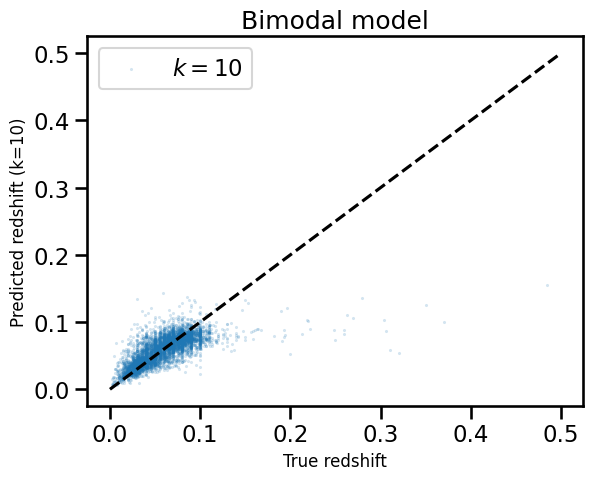

In [170]:
plt.scatter(zs_im, np.mean(zs_im[inds_top_im_imlc], axis=1), s=0.5, alpha=0.2, label=rf'$k={k}$')
plt.plot(np.linspace(0, 0.5, 100), np.linspace(0, 0.5, 100), 'k--')
plt.xlabel('True redshift', fontsize=12)
plt.ylabel(f'Predicted redshift (k={k})', fontsize=12)
plt.title('Bimodal model')
plt.legend()

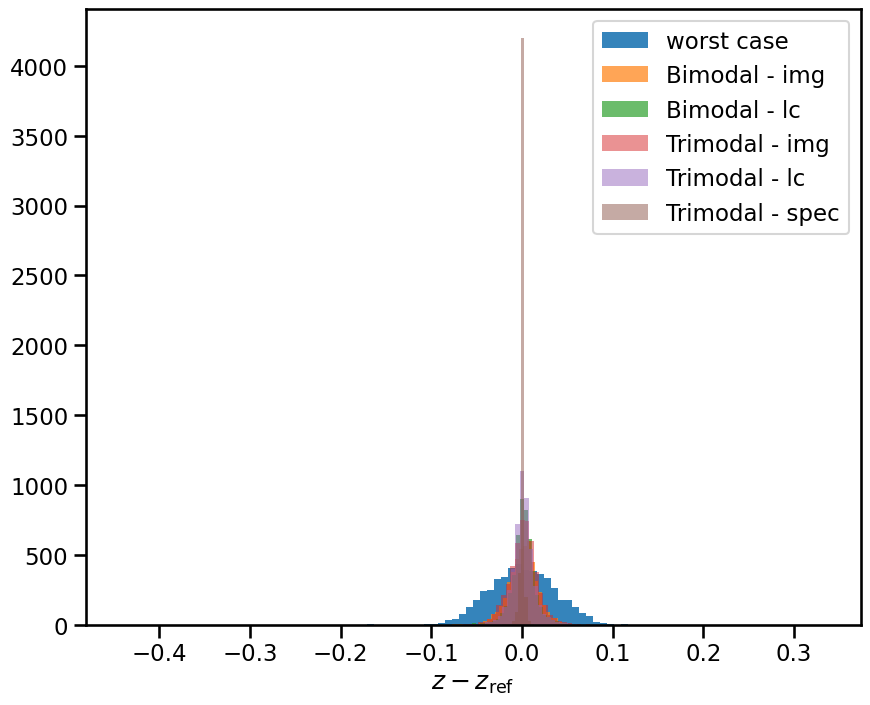

In [209]:
worst_case = np.random.choice(zs_im, size=len(zs_im), replace=True)- zs_im
diff_im_bi = np.mean(zs_im[inds_top_im_imlc[:]], axis=1) - zs_im
diff_im_tri = np.mean(zs_im[inds_top_im_tri[:]], axis=1) - zs_im
diff_im_tri_red = np.mean(zs_im[inds_top_im_tri_red[:]], axis=1) - zs_im

diff_lc_bi = np.mean(zs_im[inds_top_lc_imlc[:]], axis=1) - zs_im
diff_lc_tri = np.mean(zs_im[inds_top_lc_tri[:]], axis=1) - zs_im
diff_lc_tri_red = np.mean(zs_im[inds_top_lc_tri_red[:]], axis=1) - zs_im


diff_sp_tri = np.mean(zs_im[inds_top_sp_tri[:]], axis=1) - zs_im
diff_sp_tri_red = np.mean(zs_im[inds_top_sp_tri_red[:]], axis=1) - zs_im

plt.figure(figsize = (10,8))
plt.hist(worst_case, bins=100, alpha=0.9, label='worst case')
plt.hist(diff_im_bi, bins=100, alpha=0.7, label='Bimodal - img')
plt.hist(diff_lc_bi, bins=100, alpha=0.7, label='Bimodal - lc')
plt.hist(diff_im_tri, bins=100, alpha=0.5, label='Trimodal - img')
plt.hist(diff_lc_tri, bins=100, alpha=0.5, label='Trimodal - lc')
plt.hist(diff_sp_tri, bins=100, alpha=0.5, label='Trimodal - spec')

plt.xlabel(r"$z - z_{\rm ref}$")
plt.legend()
plt.show()

In [228]:
print(f'------------------------')
print(f'The mean average error for worst case {np.mean(np.abs(worst_case[np.where(worst_case == worst_case)])):.5f}')
print(f'The mean average error for bimodal with img {np.mean(np.abs(diff_im_bi[np.where(diff_im_bi == diff_im_bi)])):.5f}')
print(f'The mean average error for trimodal with img {np.mean(np.abs(diff_im_tri[np.where(diff_im_tri == diff_im_tri)])):.5f}')
print(f'The mean average error for trimodal(mod) with img {np.mean(np.abs(diff_im_tri_red[np.where(diff_im_tri_red == diff_im_tri_red)])):.5f}')

print(f'------------------------')
print(f'The mean average error for bimodal with lc {np.mean(np.abs(diff_lc_bi[np.where(diff_lc_bi == diff_lc_bi)])):.5f}')
print(f'The mean average error for trimodal with lc {np.mean(np.abs(diff_lc_tri[np.where(diff_lc_tri == diff_lc_tri)])):.5f}')
print(f'The mean average error for trimodal(mod) with lc {np.mean(np.abs(diff_lc_tri_red[np.where(diff_lc_tri_red == diff_lc_tri_red)])):.5f}')

print(f'------------------------')
print(f'The mean average error for trimodal with sp {np.mean(np.abs(diff_sp_tri[np.where(diff_sp_tri == diff_sp_tri)])):.5f}')
print(f'The mean average error for trimodal(mod) with sp {np.mean(np.abs(diff_sp_tri_red[np.where(diff_sp_tri_red == diff_sp_tri_red)])):.5f}')


------------------------
The mean average error for worst case 0.03083
The mean average error for bimodal with img 0.01381
The mean average error for trimodal with img 0.01330
The mean average error for trimodal(mod) with img 0.01454
------------------------
The mean average error for bimodal with lc 0.01076
The mean average error for trimodal with lc 0.01025
The mean average error for trimodal(mod) with lc 0.01150
------------------------
The mean average error for trimodal with sp 0.00111
The mean average error for trimodal(mod) with sp 0.00056


Text(0.5, 0, 'z')

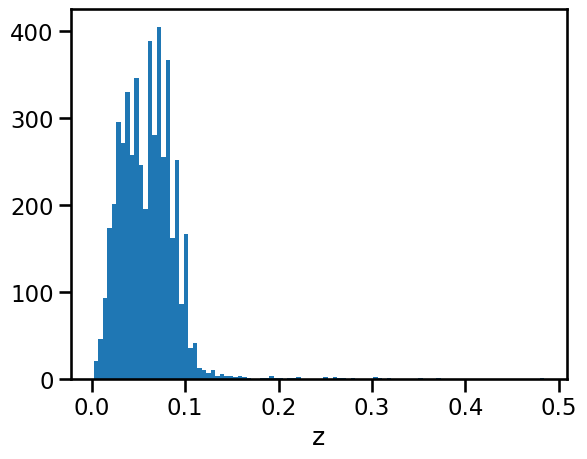

In [207]:
plt.hist(zs_im,bins = 100);
plt.xlabel('z')

In [210]:
from sklearn.linear_model import LinearRegression

In [225]:
def get_linearR2(X):
    reg = LinearRegression().fit(X.cpu().detach().numpy(), zs_im[:,np.newaxis])
    return reg.score(X.cpu().detach().numpy(), zs_im[:,np.newaxis])

In [231]:
print(f'------------------------')
print(f'The R2 for linear regression for bimodal with img {get_linearR2(ims_embs_imlc):.3f}')
print(f'The R2 for linear regression for trimodal with img {get_linearR2(ims_embs_tri):.3f}')
print(f'The R2 for linear regression for trimodal(mod) with img {get_linearR2(ims_embs_tri_red):.3f}')
# lc
print(f'------------------------')
print(f'The R2 for linear regression for bimodal with lc {get_linearR2(lc_embs_imlc):.3f}')
print(f'The R2 for linear regression for trimodal with lc {get_linearR2(lc_embs_tri):.3f}')
print(f'The R2 for linear regression for trimodal(mod) with lc {get_linearR2(lc_embs_tri_red):.3f}')
print(f'------------------------')
# spectral
print(f'The R2 for linear regression for trimodal with sp {get_linearR2(sp_embs_tri):.3f}')
print(f'The R2 for linear regression for trimodal(mod) with sp {get_linearR2(sp_embs_tri_red):.3f}')

------------------------
The R2 for linear regression for bimodal with img 0.476
The R2 for linear regression for trimodal with img 0.498
The R2 for linear regression for trimodal(mod) with img 0.455
------------------------
The R2 for linear regression for bimodal with lc 0.592
The R2 for linear regression for trimodal with lc 0.584
The R2 for linear regression for trimodal(mod) with lc 0.542
------------------------
The R2 for linear regression for trimodal with sp 0.955
The R2 for linear regression for trimodal(mod) with sp 0.916
